In [1]:
# Determine if this is a benchmarking run
try:
    __benchmark__
except NameError:
    __benchmark__ = False

# Basics: Exoplanet systems
Here we'll discuss how to instantiate an exoplanet system and compute its full light curve.

## Imports

In [1]:
import starry
import numpy as np
import matplotlib.pyplot as pl

In [2]:
%matplotlib inline

## Creating a star

This is as easy as it gets:

In [3]:
star = starry.Star()

The `Star` object is optimized for computing exoplanet transits and secondary eclipses, so you don't have too much freedom in settings its properties. For one, its radius and luminosity are fixed at unity: this sets the units for the planetary properties, since the planet radius, semi-major axis, and luminosity are specified in stellar units. You also don't get to specify a rotation axis or rotational period: the star is assumed to be spotless, so it has no intrinsic phase curve. If you want to do something involving stellar rotation, you'll need to instantiate a `Map` object directly. Check out the `Spotted star` tutorial for some ideas.

What you **can** do is specify the limb darkening parameters of the star. By default, the star is instantiated with a second-degree spherical harmonic `LimbDarkenedMap` (you can increase the degree by providing a number in the call to `starry.Star`). Let's give the stellar map a linear and a quadratic limb-darkening coefficient:

In [4]:
star.map[1] = 0.40
star.map[2] = 0.26

Here's what that looks like:

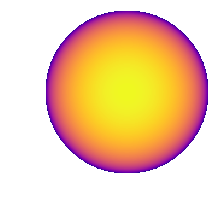

In [6]:
star.map.show()

In [7]:
if __benchmark__:
    assert np.allclose(star.map.evaluate(x=[0,1,0], y=[0,0,1]), np.array([0.3866112, 0.13144781, 0.13144781]))

## Creating a planet

This one is a bit more fun:

In [6]:
planet = starry.Planet(lmax=5, r=0.1, L=5e-3, porb=1, prot=1, a=30, Omega=30, ecc=0.3, w=30)

Here we've instantiated a planet with a fifth degree surface map, a radius that is one-tenth that of the star, a luminosity that is one-two-hundredth that of the star, an orbital period of 1 day, a rotational period of 1 day, and a semi-major axis that's thirty times the stellar radius. This is essentially a tidally-locked hot Jupiter.

**NOTE:** The default rotational period for planets is **infinity**, so if you don't specify `prot`, the planet's surface map will not rotate as the planet orbits the star and there will be no phase curve variation. For planets whose emission tracks the star--i.e., a hot Jupiter with a hotspot--set `prot=porb`.

There are a bunch of other settings related to the orbit, so check out the docs for those. By default, planets are given zero eccentricity, edge-on inclination, and zero obliquity, and $t = 0$ corresponds to a transiting configuration.

OK, the next thing we get to do is specify a planet map. For simplicity, let's just create a random one:

In [7]:
np.random.seed(123)
for l in range(1, planet.map.lmax + 1):
    for m in range(-l, l + 1):
        planet.map[l, m] = 0.01 * np.random.randn()

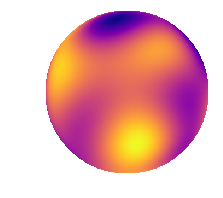

In [8]:
planet.map.show()

Note that when instantiating a map for a `starry.Planet` instance, **the map should be defined as it would appear during secondary eclipse.** That is, the image you see above is the full dayside of the planet, with the orbital plane slicing the planet's equator and ecliptic north pointing up. **This is true even for planets that aren't edge on and don't have secondary eclipses.** The map is always defined as if it were seen edge on, with the orbital plane along the $xy$ plane and the planet behind the star.

Now, it's probably a good idea to ensure we didn't end up with negative specific intensity anywhere:

In [9]:
planet.map.minimum()

0.22095381687604723

In [12]:
if __benchmark__:
    assert np.allclose([planet.map.minimum()], [0.22095381687604723]) 

## Creating a system

Now that we have a star and a planet, we can instantiate a planetary system:

In [10]:
system = starry.System([star, planet])
print(system)

<STARRY 1-planet system>


The first argument to a `starry.System` call is an array of bodies, starting with a `Star` object, and followed by any number of planets. At present, that's all `starry.System` will accept: star-star and planet-moon systems aren't yet supported. 

**NOTE:** You can, of course, manually model other kinds of systems by instantiating a `starry.Map` for each body, doing the orbit calculations yourself, and calling the `flux()` method of the maps once you know the positions of all the bodies.

There are some other arguments you can provide--notably an exposure time (`exptime`) argument--if the exposure time of your data is long enough to affect the light curve shape. Check out the docs for more information.

## Computing light curves

We're ready to compute the full system light curve:

In [11]:
time = np.linspace(-0.25, 3.25, 10000)
%time system.compute(time)

CPU times: user 38.3 ms, sys: 916 µs, total: 39.2 ms
Wall time: 39.1 ms


Cool -- `starry` computed 10,000 cadences in 35 ms. Let's check it out:

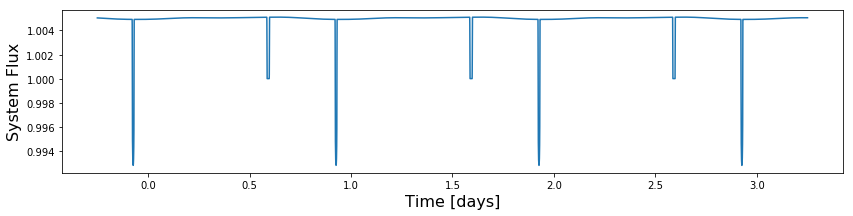

In [12]:
fig, ax = pl.subplots(1, figsize=(14, 3))
ax.set_xlabel('Time [days]', fontsize=16)
ax.set_ylabel('System Flux', fontsize=16)
ax.plot(time, system.flux);

In [19]:
if __benchmark__:
    assert np.allclose([np.min(system.flux), np.max(system.flux)], [0.992787453371187, 1.0051091461483344])

We can also plot the stellar and planetary light curves individually:

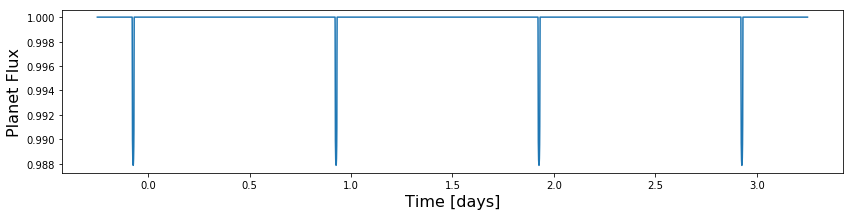

In [20]:
# This will show you only the transits
fig, ax = pl.subplots(1, figsize=(14, 3))
ax.set_xlabel('Time [days]', fontsize=16)
ax.set_ylabel('Planet Flux', fontsize=16)
ax.plot(time, star.flux);

In [21]:
if __benchmark__:
    assert np.allclose([np.min(star.flux), np.max(star.flux)], [0.9878665127810682, 1.0])

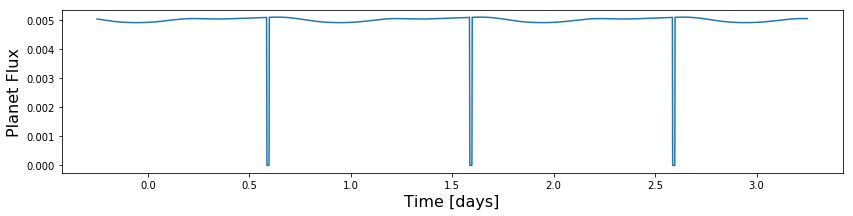

In [22]:
# This will show you only the planet's flux (phase curve + secondary eclipse)
fig, ax = pl.subplots(1, figsize=(14, 3))
ax.set_xlabel('Time [days]', fontsize=16)
ax.set_ylabel('Planet Flux', fontsize=16)
ax.plot(time, planet.flux);

In [23]:
if __benchmark__:
    assert np.allclose([np.min(planet.flux), np.max(planet.flux)], [0.0, 0.00510914618136758])
    assert np.argmin(planet.flux) == 2390

And, just for fun, the planet's orbit (the sky plane is the $xy$ plane, with $y$ pointing up and $x$ pointing to the right; $z$ points toward the observer):

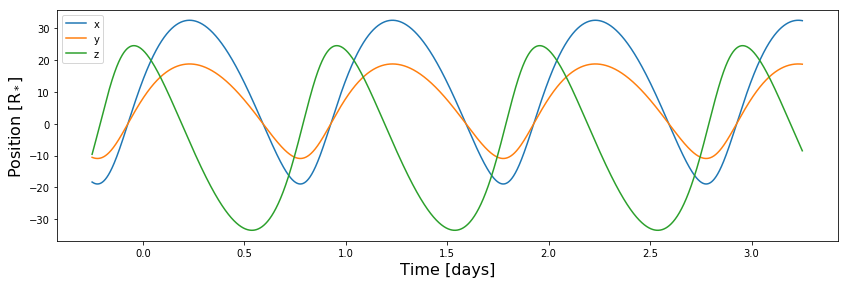

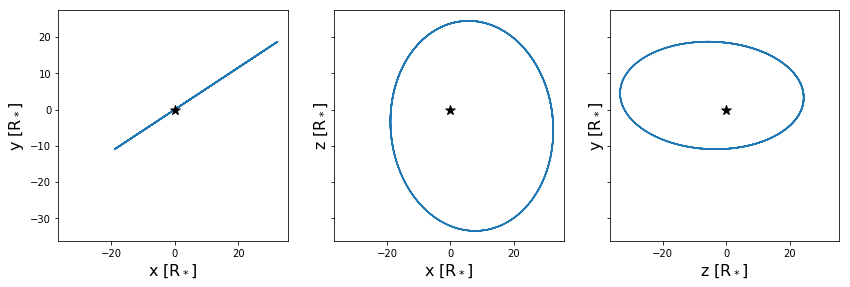

In [24]:
fig, ax = pl.subplots(1, figsize=(14, 4.25))
ax.plot(time, planet.x, label='x')
ax.plot(time, planet.y, label='y')
ax.plot(time, planet.z, label='z')
ax.set_ylabel(r'Position [R$_*$]', fontsize=16);
ax.set_xlabel(r'Time [days]', fontsize=16);
ax.legend();

fig, ax = pl.subplots(1,3, sharex=True, sharey=True, figsize=(14, 4.25))
ax[0].plot(planet.x, planet.y)
ax[1].plot(planet.x, planet.z)
ax[2].plot(planet.z, planet.y)
for n in [0, 1, 2]:
    ax[n].scatter(0, 0, marker='*', color='k', s=100, zorder=10)
ax[0].set_xlabel(r'x [R$_*$]', fontsize=16);
ax[0].set_ylabel(r'y [R$_*$]', fontsize=16);
ax[1].set_xlabel(r'x [R$_*$]', fontsize=16);
ax[1].set_ylabel(r'z [R$_*$]', fontsize=16);
ax[2].set_xlabel(r'z [R$_*$]', fontsize=16);
ax[2].set_ylabel(r'y [R$_*$]', fontsize=16);

In [25]:
if __benchmark__:
    assert np.allclose(planet.x[500:505], np.array([-0.30964744, -0.24076855, -0.17188729, -0.10300434, -0.03412038]))
    assert np.allclose(planet.y[500:505], np.array([-0.17877503, -0.13900779, -0.09923917, -0.05946958, -0.01969941]))
    assert np.allclose(planet.z[500:505], np.array([23.65600332, 23.67490184, 23.6935674,  23.71200035, 23.73020103]))